In [38]:
# Import Libraries 
import cv2
from plantcv import plantcv as pcv



In [39]:
class options:
    def __init__(self):
        self.image = "testRGB.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "vis_nir_test_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

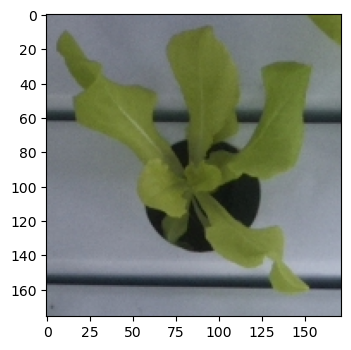

In [40]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)

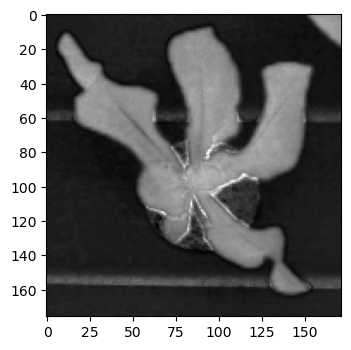

In [41]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_img - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')

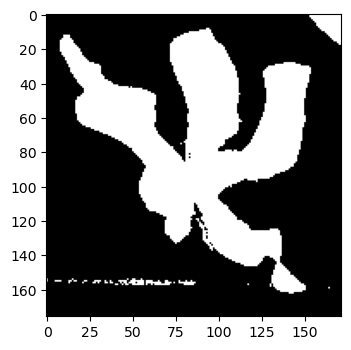

In [42]:
# Threshold the Saturation image

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the background then standard threshold is done.
#                 If the object is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=90, max_value=255, object_type='light')



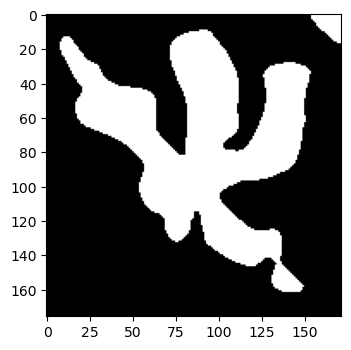

In [43]:
# Median Blur

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=7)

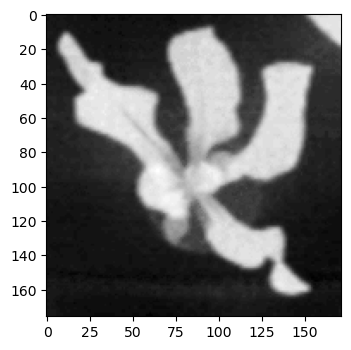

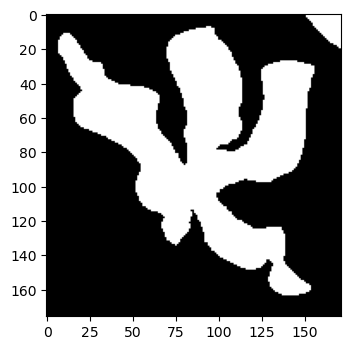

In [44]:
# Convert RGB to LAB and extract the blue-yellow channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue-yellow channel image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=135, max_value=255, object_type='light')

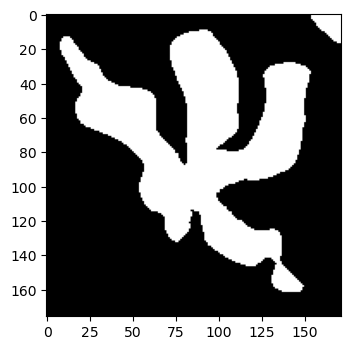

In [45]:
# Join the thresholded saturation and blue-yellow images

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_and(bin_img1=s_mblur, bin_img2=b_thresh)

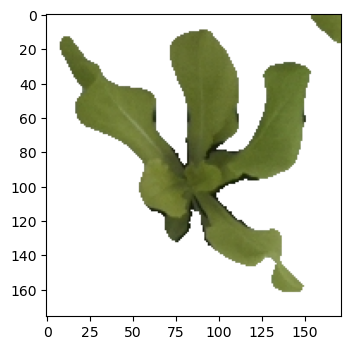

In [46]:
# Apply Mask

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')

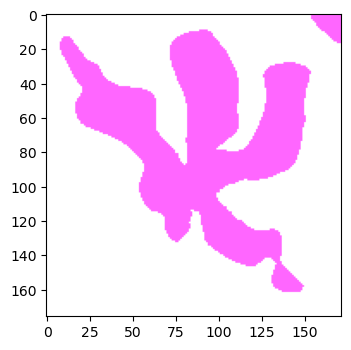

In [47]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects,obj_hierarchy = pcv.find_objects(img=masked, mask=bs)

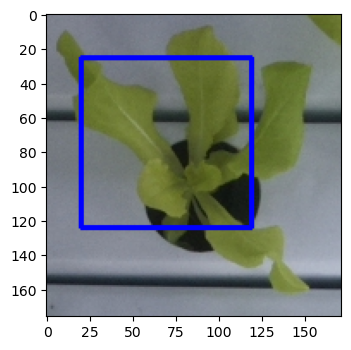

In [48]:
# This image is relatively large, and it's making it so not all sides of the ROI are showing up 
# when plotted in Jupyter. There is an optional line_thickness parameter in the params class.
# Default line_thickness = 5. 
pcv.params.line_thickness = 2


# Define Region of Interest (ROI) 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy = pcv.roi.rectangle(img=img, x=20, y=25, h=100, w=100)



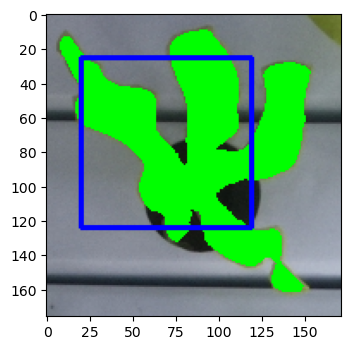

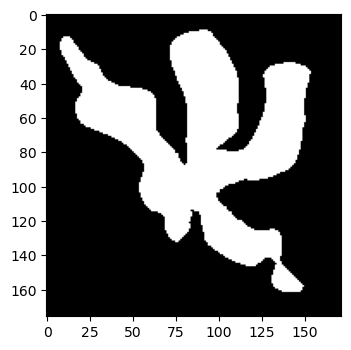

In [49]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                              roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects,
                                                              obj_hierarchy=obj_hierarchy,
                                                              roi_type='partial')



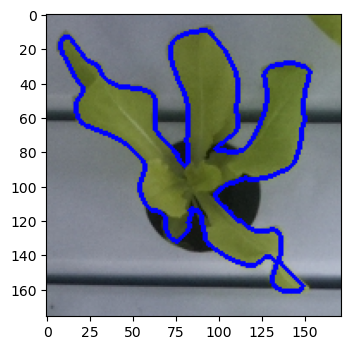

In [50]:
# Object combine the kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy)

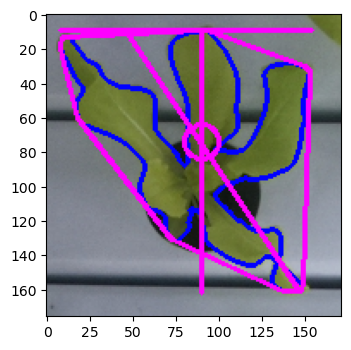

In [55]:
############### Analysis ################  
  
# Find shape properties

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask) # LABEL = "VIS" not working



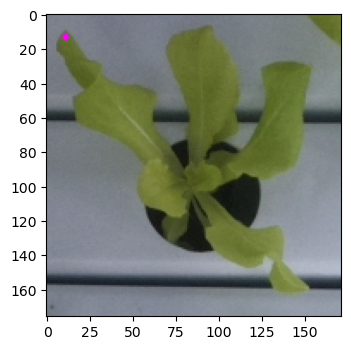

In [60]:
# Search for accute vertices 

# Inputs:
#   img - RGB or grayscale image 
#   obj - A contour of the plant object 
#   win - The pre and post point distances on which to calculate 
#            the angle of the focal point on which to calculate 
#            the angle
#   thresh - Threshold to set for acuteness
#   sep - The number of contour points to search within for the 
#         most acute value 
#   label -Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

acute_points_list, points_img = pcv.acute_vertex(img=img, obj=obj, win=30, thresh=25, sep=100)  # LABEL = "VIS" not working